In [268]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [291]:
def LoadData(FileName):
    data = np.loadtxt(FileName)
    return data[:, :-1], data[:, -1]
def ClipAlpha(alpha, L, H):
    if alpha < L:
        return L
    elif alpha > H:
        return H
    else:
        return alpha
def GetRandJ(i, m):
    j = i
    while(i == j):
        j = int(np.random.uniform(0, m))
    return j
class optStruct:
    def __init__(self, xMat, yMat, C, tor, KTuple):
        self.xMat = xMat
        self.yMat = yMat
        self.C = C
        self.tor = tor
        self.KTuple = KTuple
        self.m = dataArr.shape[0]
        self.alphas = np.mat(np.zeros((self.m, 1)))
        self.b = 0
        self.errorCache = np.mat(np.zeros((self.m, 2)))
        self.K = np.mat(np.zeros((self.m, self.m)))
        for i in range(self.m):
            self.K[:, i] = KernelTrans(self.xMat, self.xMat[i, :], self.KTuple)

def SelectJ(i, oS, Ei):
    maxDiff = 0
    indexJ = -1
    Ej = 0
    oS.errorCache[i] = [1, Ei]
    valideErrorCacheList = np.nonzero(oS.errorCache[:, 0].A)[0]
    if len(valideErrorCacheList) > 1:
        for j in valideErrorCacheList:
            if j == i:
                continue
            Ej = Ek(oS, j)
            if abs(Ei - Ej) > maxDiff:
                maxDiff = abs(Ei - Ej)
                indexJ = j
    else:
        indexJ = GetRandJ(i, oS.m)
        Ej = Ek(oS, indexJ)
    return indexJ, Ej
def updateEk(oS, k):
    oS.errorCache[k] = [1, Ek(oS, k)]
def innerLoop(i, oS):
    Ei = Ek(oS, i)
    if (oS.yMat[i] * Ei < -oS.tor and oS.alphas[i] < oS.C) or (oS.yMat[i] * Ei > oS.tor and oS.alphas[i] > 0):
        j, Ej = SelectJ(i, oS, Ei)
        alphaIOld = oS.alphas[i].copy()
        alphaJOld = oS.alphas[j].copy()
        if oS.yMat[i] != oS.yMat[j]:
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H:
            return 0
        #oS.alphas[j] += oS.yMat[j] * (Ei - Ej) / Eta(oS.xMat, i, j)
        oS.alphas[j] += oS.yMat[j] * (Ei - Ej) / (oS.K[i, i] + oS.K[j, j] - 2 * oS.K[i, j])
        oS.alphas[j] = ClipAlpha(oS.alphas[j], L, H)
        updateEk(oS, j)
        if abs(oS.alphas[j] - alphaJOld) < oS.tor:
            return 0
        oS.alphas[i] += oS.yMat[i] * oS.yMat[j] * (alphaJOld - oS.alphas[j])
#        b1 = -Ei + (alphaIOld - oS.alphas[i]) * oS.yMat[i] * K(oS.xMat, i, i) + \
#            (alphaJOld - oS.alphas[j]) * oS.yMat[j] * K(oS.xMat, i, j) + oS.b
#        b2 = -Ej + (alphaIOld - oS.alphas[i]) * oS.yMat[i] * K(oS.xMat, i, j) + \
#            (alphaJOld - oS.alphas[j]) * oS.yMat[j] * K(oS.xMat, j, j) + oS.b
        b1 = -Ei + (alphaIOld - oS.alphas[i]) * oS.yMat[i] * oS.K[i, i] + \
            (alphaJOld - oS.alphas[j]) * oS.yMat[j] * oS.K[j, i] + oS.b
        b2 = -Ej + (alphaIOld - oS.alphas[i]) * oS.yMat[i] * oS.K[i, j] + \
            (alphaJOld - oS.alphas[j]) * oS.yMat[j] * oS.K[j, j] + oS.b
        if oS.alphas[j] < C and oS.alphas[j] > 0:
            oS.b = float(b2)
        elif oS.alphas[i] < C and oS.alphas[i] > 0:
            oS.b = float(b1)
        else:
            oS.b = float(b1 + b2)/2
        return 1
    else:
        return 0

def SMO(dataArr, dataLab, C, tor, KTuple = ('linear', 1.0), numIter = 100):
    m, n = dataArr.shape
    xMat = np.mat(dataArr)
    yMat = np.mat(dataLab).T
    alphas = np.zeros((m, 1))
    b = 0
    oS = optStruct(xMat, yMat, C, tor, KTuple)
    iter = 0
    entireSet = True
    alphaPairsChanged = 0
    while((iter < numIter) and (alphaPairsChanged > 0 or entireSet)):
        alphaPairsChanged = 0
        if entireSet:
            for i in range(oS.m):
                alphaPairsChanged += innerLoop(i, oS)
            iter += 1
        else:
            nonBoundIs = np.nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerLoop(i, oS)
            iter += 1
        if entireSet:
            entireSet = False
        elif alphaPairsChanged == 0:
            entireSet = True
    return oS.alphas, oS.b
    
def K(xMat, ind1, ind2):
    return (xMat[ind1, :] * xMat[ind2, :].T)[0, 0]
def Eta(xMat, ind1, ind2):
    return K(xMat, ind1, ind1) + K(xMat, ind2, ind2) - 2 * K(xMat, ind1, ind2)
def Ek(oS, k):
#    return float(np.multiply(oS.alphas, oS.yMat).T * KernelTrans(oS.xMat, oS.xMat[k, :], oS.KTuple)) + \
#            oS.b - float(oS.yMat[k])
    return float(np.multiply(oS.alphas, oS.yMat).T * oS.K[:, k]) + oS.b - float(oS.yMat[k])

def KernelTrans(X, A, KTuple):
    m, n = X.shape
    K = np.mat(np.zeros((m, 1)))
    if KTuple[0] == 'linear':
        return X * A.T
    elif KTuple[0] == 'rgf':
        for j in range(m):
            K[j] = (X[j, :] - A) * (X[j, :] - A).T
        return np.exp(K / (-2 * KTuple[1] ** 2))
    else:
        raise NameError('The kernel is not recognized')
def Plot(dataArr, dataLab, weight, b):
    m, n = dataArr.shape
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(dataArr[dataLab == 1][:, 0], dataArr[dataLab == 1][:, 1])
    ax.scatter(dataArr[dataLab == -1][:, 0], dataArr[dataLab == -1][:, 1], c = 'red')
    X = dataArr[:, 0].reshape((1, m))[0]
    X = np.arange(2, 7, 0.001)
    Y = (-b - X * weight[0]) / weight[1]
    ax.plot(X, Y, c = 'green')
    plt.show()
def GetWeight(alphas, dataArr, dataLab):
    xMat = np.mat(dataArr)
    yMat = np.mat(dataLab).T
    m, n = dataArr.shape
    weight = np.zeros((n, 1))
    for i in range(m):
        weight += np.multiply(alphas[i] * yMat[i], xMat[i, :].T)
    return weight.reshape((1, n))[0]

def TestLinear():
    dataArr, dataLab = LoadData('testSet.txt')
    xMat = np.mat(dataArr)
    yMat = np.mat(dataLab).T
    m, n = dataArr.shape
    tor = 0.001
    C = 0.6
    alphas, b = SMO(dataArr, dataLab, C, tor)
    weight = GetWeight(alphas, dataArr, dataLab)
    Plot(dataArr, dataLab, weight, b)
    print('alpha is {}\nb is {}'.format(alphas[alphas > 0], b))
    error = 0
    alphas = np.mat(np.array(alphas).reshape((m, 1)))
    for i in range(m):
        predict = float(np.multiply(alphas, yMat).T * xMat * xMat[i, :].T) + float(b)
        if np.sign(predict) != np.sign(dataLab[i]):
            error += 1
    print(error / m)

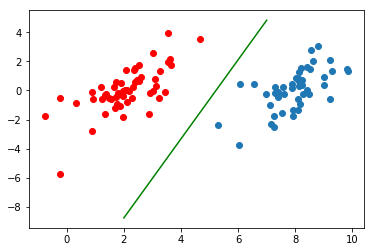

alpha is [[0.09614472 0.00889974 0.01290241 0.04883761 0.01540168 0.04364663
  0.05905895 0.15609533 0.02071288]]
b is -3.008099139867237
0.0


In [249]:
TestLinear()

In [258]:
def TestRBF(KTuple = ('rgf', 1.3)): # Radial Gaussian Function
    dataArr, dataLab = LoadData('testSetRBF.txt')
    xMat = np.mat(dataArr)
    yMat = np.mat(dataLab).T
    m, n = dataArr.shape

    tor = 0.0001
    C = 200
    alphas, b = SMO(dataArr, dataLab, C, tor, KTuple, numIter = 100)
    print('alpha = {}\nb = {}'.format(alphas[alphas > 0], b))
    error = 0
    alphas = np.mat(np.array(alphas).reshape((m, 1)))
    for i in range(m):
        predict = float(np.multiply(alphas, yMat).T * KernelTrans(xMat, xMat[i, :], KTuple)) + float(b)
        if np.sign(predict) != np.sign(dataLab[i]):
            error += 1
    print(error / m)

In [259]:
TestRBF()

alpha = [[4.91560101e+01 5.60905212e+01 8.43769499e-15 1.42108547e-14
  1.23786891e+01 6.21586540e+01 6.95913668e+01 1.99999950e+02
  1.26234433e+01 8.32348514e+00 3.79624019e+01 8.88178420e-16
  2.66453526e-15 1.18679185e+01 1.50907052e+00 3.10774763e+00
  2.05937795e+00 4.69111440e+01 5.58392943e+00 6.58673942e+01
  4.28724024e+01 7.62167290e+00 6.19677200e+00 5.50815928e+00
  2.82982693e+01 7.61317296e+01 1.45531209e+01 1.15463195e-14
  8.66014687e-01 8.88178420e-16]]
b = -39.689765241658336
0.15


In [292]:
def loadImages(dirName):
    hwLabels = []
    trainingFileList = os.listdir(dirName)           #load the training set
    m = len(trainingFileList)
    trainingMat = np.zeros((m,1024))
    for i in range(m):
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]     #take off .txt
        classNumStr = int(fileStr.split('_')[0])
        if classNumStr == 9:
            hwLabels.append(-1)
        else:
            hwLabels.append(1)
    return trainingMat, hwLabels    

def testDigits(KTuple=('rgf', 10)):
    dataArr,labelArr = loadImages('trainingDigits')
    alphas, b = SMO(dataArr, labelArr, 200, 0.0001, KTuple, 10000)
    datMat = np.mat(dataArr)
    labelMat = np.mat(labelArr).transpose()
    svInd = np.nonzero(alphas.A > 0)[0]
    sVs = datMat[svInd] 
    labelSV = labelMat[svInd]
    m,n = np.shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = KernelTrans(sVs, datMat[i,:], KTuple)
        predict = kernelEval.T * np.multiply(labelSV, alphas[svInd]) + b
        if np.sign(predict) != np.sign(labelArr[i]):
            errorCount += 1
    print ("the training error rate is: {}".format((float(errorCount)/m)))
    dataArr, labelArr = loadImages('testDigits')
    errorCount = 0
    datMat = np.mat(dataArr)
    labelMat = np.mat(labelArr).transpose()
    m, n = np.shape(datMat)
    for i in range(m):
        kernelEval = KernelTrans(sVs, datMat[i,:], KTuple)
        predict = kernelEval.T * np.multiply(labelSV, alphas[svInd]) + b
        if np.sign(predict) != np.sign(labelArr[i]):
            errorCount += 1    
    print ("the test error rate is: {}".format((float(errorCount)/m)))

In [ ]:
testDigits()